In [1]:
# # 如果有使用 coloab 再執行此 cell
# from google.colab import drive
# drive.mount('/gdrive')
# !ln -s /gdrive/MyDrive/Credit_Card/ /content/

In [2]:
# !pip3  install -U mlxtend
# !pip3  install -U sklearn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df_X = pd.read_csv("X_train.csv")
df_X = df_X.set_index("txkey")

In [5]:
df_y = pd.read_csv("y_train.csv")
df_y = df_y.set_index("txkey")

In [6]:
df_X.shape, df_y.shape

((1217431, 21), (1521787, 1))

In [7]:
# 使 y 與 x_train 同樣尺度
x_train = df_X
y_train = df_y.loc[x_train.index]
print(x_train.shape, y_train.shape)

(1217431, 21) (1217431, 1)


In [8]:
# cut, index=x_train.index
nn = y_train.shape[0]
indexList = list(x_train.index)
cut = int(nn/4)
newID = indexList[0:cut][-25000:] + indexList[cut:2*cut][-25000:] +\
        indexList[2*cut:3*cut][-25000:] + indexList[cut:][-25000:]
xf = x_train.loc[newID]
yf = y_train.loc[newID]
print(xf.shape, yf.shape)
# print(len(newID))

(100000, 21) (100000, 1)


# Feature Selection

In [9]:
import sklearn
sklearn.__version__

'0.24.2'

In [10]:
import mlxtend
mlxtend.__version__

'0.18.0'

In [11]:
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [12]:
# ravel y to (n, )
# y_train = y_train.values.ravel()
# print(y_train.shape)
yf = yf.values.ravel()
print(yf.shape)

(100000,)


In [ ]:
# Selecting the Best important features according to SVM

svc_ = SVC(kernel='rbf', probability=True)
sfs_selector = SFS(svc_, k_features = 3, forward=False, 
                   floating=False, verbose=2, scoring="accuracy", cv = 5, n_jobs=2)
sfs_selector.fit(xf, yf)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
k_f_idx = sfs_selector.k_feature_idx_
print(k_f_idx)
k_f_name = sfs_selector.k_feature_names_
print(k_f_name)
print(sfs_selector.k_score_)

In [ ]:
# k_subset = sfs_selector.subsets_
# print(k_subset)
print(type(sfs_selector.k_feature_idx_))

In [ ]:
df_sfs = pd.DataFrame({'feature index':[str(sfs_selector.k_feature_idx_)], 
                       'score':[sfs_selector.k_score_]})
# df_sfs['feature names'] = list(sfs_selector.k_feature_names_)
df_sfs
# print(df_sfs)

In [ ]:
# # x_train.columns[sfs_selector.get_support()]
# X_feature_set = x_train.loc[:,k_f_name]
# print(X_feature_set.shape)

# Training

In [174]:
# Build a classifier to train
# svc_ = SVC(kernel='rbf', probability=True)

In [175]:
# 特徵選取後的 dataset
x_sfs = xf.loc[:, list(sfs_selector.k_feature_names_)]
y_sfs = yf
print(x_sfs.shape, y_sfs.shape)

(50000, 5) (50000,)


In [176]:
# fit the model svc
model = svc_.fit(x_sfs, y_sfs)

# Testing : verify with real distribution data

In [177]:
from sklearn.model_selection import train_test_split
# df_X_train, df_X_test = train_test_split(df_X_set, test_size=0.20, random_state=10)
x_test = pd.read_csv("X_test.csv")
# x_test = x_test.set_index("txkey")
x_test.shape

(304357, 22)

In [192]:
# 選 1000 個
import random
n1 = x_test.shape[0]
testID = random.sample(range(0, n1), 1000)
print(len(testID))

1000


In [193]:
xtest_sfs = x_test.loc[testID].loc[:, list(sfs_selector.k_feature_names_)]
print(xtest_sfs.shape)

(1000, 5)


In [194]:
# xtest_sfs = xtest_sfs.set_index("txkey")
# # "None of ['txkey'] are in the columns"

In [195]:
y_test0 = df_y.drop(labels=y_train.index, axis=0)
# 
yID = random.sample(list(y_test0.index), 1000)
print(len(yID))
y_test = y_test0.loc[yID]
print(y_test.shape)

1000
(1000, 1)


In [196]:
# df_y_train = df_y.loc[df_X_train.index]
# df_y_test = df_y.loc[df_X_test.index]

In [197]:
# # Train it on the entire training data set
# svm.fit(x_train, y_train)

# Get predictions on the test set
print('Starting predicting...')
y_pred = svm.predict(xtest_sfs)
print(y_pred.shape)

Starting predicting...
(1000,)


# Evaluation

y_train is a true vector

In [198]:
# Return the mean accuracy on the given test data and labels.
score_rbf = svm.score(xtest_sfs, y_test)
print('mean accuracy: ', score_rbf)

mean accuracy:  0.984


In [199]:
from sklearn.metrics import roc_auc_score
print('roc auc: ', roc_auc_score(y_test, y_pred))

roc auc:  0.49848024316109424


In [200]:
from sklearn.metrics import accuracy_score
print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.984


In [201]:
from sklearn.metrics import recall_score
print('recall: ', recall_score(y_test, y_pred))

recall:  0.0


# sklearn Metrics

In [202]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, average_precision_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, classification_report 

In [203]:
cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int), labels=[0,1])
cm

array([[984,   3],
       [ 13,   0]], dtype=int64)

In [204]:
tn, fp, fn, tp  = confusion_matrix(y_test, (y_pred > th).astype(int)).ravel()
print(tn, fp, fn, tp)

984 3 13 0


In [205]:
th = 0.5
print("precision_score = ", precision_score(y_test,(y_pred > th).astype(int)))
print("recall_score = ", recall_score(y_test,(y_pred > th).astype(int)))
print("f1_score = ", f1_score(y_test,(y_pred > th).astype(int)))

precision_score =  0.0
recall_score =  0.0
f1_score =  0.0


Conclusions DataFrame

In [206]:
import numpy as np
maps = {'Accuracy':accuracy_score(y_test, y_pred), 
        'Precision':precision_score(y_test,(y_pred > th).astype(int)), 
        'Recall':recall_score(y_test,(y_pred > th).astype(int)), 
        'f1-score':f1_score(y_test,(y_pred > th).astype(int)), 
        'AUC':np.round(roc_auc_score(y_test, y_pred), 3)}
concl = pd.DataFrame(maps, index=['SVM'])
concl

,Accuracy,Precision,Recall,f1-score,AUC
SVM,0.984,0.0,0.0,0.0,0.498


# Plot

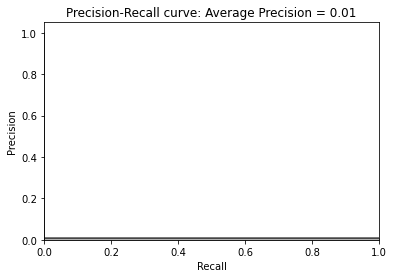

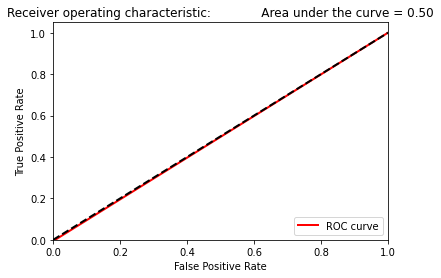

In [153]:
# SVM
precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
average_precision = average_precision_score(y_test,y_pred)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
            Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc = "lower right")
plt.show()

In [155]:
# fnscore = [(fname,socre) for fname,socre in zip(model.feature_name(),model.feature_importance())]

In [156]:
# top_feature = sorted(fnscore, key=lambda tup: tup[1], reverse=True)[:25]

# Bias and Variance ，[參考資料1](https://machinelearningmastery.com/gentle-introduction-to-the-bias-variance-trade-off-in-machine-learning/), [參考資料二]
* 一般來模型的 Bias 和 Variance 會呈現互斥的現像
* 通常來說 Bias 越低，代表可能產生 Overfitting ，而 Overfitting 通常代表 Vairance 越高，其意義代表對於 Input 資料的敏感到越高。
## How to Caculate the Model's Bias
* Bias 的定義: Bias 是模型的預測(產出)的均值與實際值的差異(Bias is the difference between the mean of these estimates and the actual value.)
* Model Bias Formula : $$ {1 \over n}\sum\limits_{k=1}^n \{{\hat{y}-y_i}\}^2 $$
## How to Caculate the Model's Variance
* Variance 定義：這與實際(y label)的 value 沒關係，而是這個組模型的穩定度，在不同 sub training set 所產出相對應的 model 對於 同一組 testing data 所預測(產出)的值的 variance .
* Variance Defintion: Variance is the amount that the estimate of the target function will change if different training data was used.
*  Model Variance Formula:$$ {1 \over N}\sum\limits_{n=1}^N {1 \over L}\sum\limits_{l=1}^l \{{ y^l(x_n) -  \bar{y}(x_n) }\}^2 $$
* N 為 testing data 的數(筆)量，L 將 training data 折成多少個 sub trainin set (N is the number of rows that is in testing set . L is the number of subset that is splited from all training set. )

## 使用不同的模型來看 Bias 與 Variance 的變化

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(df_X_train,df_y_train)
y_pred = lr.predict(X_test,)
print('auc:', roc_auc_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


auc: 0.9153174937575568


In [ ]:
df_X_train = df_X_train.reset_index(drop=True)
df_y_train = df_y_train.reset_index(drop=True)

In [ ]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
y_test

,fraud_ind
0,0
1,0
2,0
3,0
4,0
...,...
380442,0
380443,0
380444,0
380445,1


In [ ]:
from mlxtend.evaluate import bias_variance_decomp
lr = LogisticRegression()


# first calculate all the statistical parameters before pruning
mse_decision_tree, bias_decision_tree, var_decision_tree = bias_variance_decomp(lr, 
        df_X_train.to_numpy(), df_y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), 
        '0-1_loss', random_seed=123 )

# random_seed : Used to initialize a pseudo-random
# number generator for the bias-variance decomposition
print('Original Bias from un-pruned data ', np.round(bias_decision_tree, 2))
print('Original Variance from un-pruned data ', np.round(var_decision_tree, 2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

KeyboardInterrupt: ignored

In [ ]:
df_X_train.to_numpy()

array([[-0.19295789,  0.40389234,  0.54547933, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76428378, -0.62642089,  0.5442519 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.06405948,  1.00898319,  1.09937523, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.38284073,  1.67649549, -1.67643777, ...,  0.        ,
         0.        ,  0.        ],
       [-1.84862799,  1.01929519,  1.22406522, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.3556115 , -1.59310819,  1.29301376, ...,  1.        ,
         0.        ,  0.        ]])